## 1. Importing Libraries

In [1]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

from feature_engine.datetime import DatetimeFeatures

from xgboost import XGBRegressor

import joblib

import matplotlib.pyplot as plt

## 2. Display Settings

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
sklearn.set_config(transform_output="default")

## 3. Getting the Data

In [5]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/validation.csv")
test_df = pd.read_csv("data/test.csv")

In [6]:
train_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-05-12,Chennai,Kolkata,19:35:00,21:55:00,140,0.0,No Info,3597
1,Air India,2019-03-03,Delhi,Cochin,19:45:00,19:15:00,1410,2.0,No Info,12856
2,Multiple Carriers,2019-06-09,Delhi,Cochin,06:40:00,19:00:00,740,1.0,No Info,10877
3,Air India,2019-04-01,Kolkata,Banglore,20:30:00,12:00:00,930,1.0,No Info,7893
4,Jet Airways,2019-03-06,Banglore,New Delhi,14:05:00,11:25:00,1280,1.0,In-flight meal not included,13712
...,...,...,...,...,...,...,...,...,...,...
635,Air India,2019-06-06,Delhi,Cochin,06:50:00,07:40:00,1490,2.0,No Info,13381
636,Air India,2019-06-01,Kolkata,Banglore,14:15:00,16:45:00,150,0.0,No Info,6245
637,Jet Airways,2019-03-18,Banglore,New Delhi,11:40:00,20:20:00,520,1.0,No Info,13555
638,Jet Airways,2019-05-09,Kolkata,Banglore,06:30:00,04:40:00,1330,1.0,No Info,13941


### 3.1 Split the Data

In [7]:
def split_data(data):
	X = data.drop(columns="price")
	y = data.price.copy()
	return (X, y)

In [8]:
X_train, y_train = split_data(train_df)

In [9]:
X_train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Indigo,2019-05-12,Chennai,Kolkata,19:35:00,21:55:00,140,0.0,No Info
1,Air India,2019-03-03,Delhi,Cochin,19:45:00,19:15:00,1410,2.0,No Info
2,Multiple Carriers,2019-06-09,Delhi,Cochin,06:40:00,19:00:00,740,1.0,No Info
3,Air India,2019-04-01,Kolkata,Banglore,20:30:00,12:00:00,930,1.0,No Info
4,Jet Airways,2019-03-06,Banglore,New Delhi,14:05:00,11:25:00,1280,1.0,In-flight meal not included
...,...,...,...,...,...,...,...,...,...
635,Air India,2019-06-06,Delhi,Cochin,06:50:00,07:40:00,1490,2.0,No Info
636,Air India,2019-06-01,Kolkata,Banglore,14:15:00,16:45:00,150,0.0,No Info
637,Jet Airways,2019-03-18,Banglore,New Delhi,11:40:00,20:20:00,520,1.0,No Info
638,Jet Airways,2019-05-09,Kolkata,Banglore,06:30:00,04:40:00,1330,1.0,No Info


In [10]:
y_train

0       3597
1      12856
2      10877
3       7893
4      13712
       ...  
635    13381
636     6245
637    13555
638    13941
639     6270
Name: price, Length: 640, dtype: int64

In [11]:
X_val, y_val = split_data(val_df)

print(X_val.shape, y_val.shape)

(160, 9) (160,)


In [12]:
X_test, y_test = split_data(test_df)

print(X_test.shape, y_test.shape)

(200, 9) (200,)


### 3.2 Meta-info

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


## 4. Data Preprocessing

In [14]:
dt_cols = ["date_of_journey", "dep_time", "arrival_time"]

num_cols = ["duration", "total_stops"]

cat_cols = [col for col in X_train.columns if (col not in dt_cols) and (col not in num_cols)]

In [15]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [16]:
num_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="median")),
	("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

doj_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], format="mixed")),
	("scaler", StandardScaler())
])

time_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("extractor", DatetimeFeatures(features_to_extract=["hour", "minute"], format="mixed")),
	("scaler", StandardScaler())
])

In [17]:
preprocessor = ColumnTransformer(transformers=[
	("num", num_transformer, num_cols),
	("cat", cat_transformer, cat_cols),
	("doj", doj_transformer, ["date_of_journey"]),
	("time", time_transformer, ["dep_time", "arrival_time"])
])

In [18]:
preprocessor.fit_transform(X_train)

array([[-0.93274654, -1.16474885,  0.        , ...,  0.45266422,
         1.06874628,  1.82005334],
       [ 1.55290578,  1.8051287 ,  0.        , ...,  0.99366347,
         0.77724932, -0.55594694],
       [ 0.24157739,  0.32018992,  0.        , ...,  0.72316384,
         0.77724932, -1.44694705],
       ...,
       [-0.18900805,  0.32018992,  0.        , ...,  0.72316384,
         0.9229978 , -0.25894691],
       [ 1.39632926,  0.32018992,  0.        , ...,  0.18216459,
        -1.40897789,  0.92905324],
       [ 0.02628467,  0.32018992,  0.        , ..., -1.44083316,
        -1.84622333,  0.33505316]])

In [19]:
preprocessor.fit_transform(X_train).shape

(640, 33)

## 5. Model Selection

In [20]:
algorithms = {
	"Linear Regression": LinearRegression(),
	"Support Vector Machine": SVR(),
	"Random Forest": RandomForestRegressor(n_estimators=10),
	"XG Boost": XGBRegressor(n_estimators=10)
}

In [21]:
data = pd.concat([train_df, val_df], axis=0)

X_data, y_data = split_data(data)
print(X_data.shape, y_data.shape)

(800, 9) (800,)


In [22]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
	ax.plot(
		sizes,
		mean_scores,
		marker="o",
		label=label
	)

	ax.fill_between(
		x=sizes,
		y1=mean_scores - std_scores,
		y2=mean_scores + std_scores,
		alpha=0.5
	)

In [23]:
def plot_learning_curves(name, algorithm, figsize=(12, 4)):
	model = Pipeline(steps=[
		("pre", preprocessor),
		("alg", algorithm)
	])

	train_sizes, train_scores, test_scores = learning_curve(
		estimator=model,
		X=X_data,
		y=y_data,
		cv=3,
		scoring="r2",
		n_jobs=-1,
		random_state=42
	)
	
	mean_train_scores = np.mean(train_scores, axis=1)
	std_train_scores = np.std(train_scores, axis=1)
	train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

	mean_test_scores = np.mean(test_scores, axis=1)
	std_test_scores = np.std(test_scores, axis=1)
	test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

	fig, ax = plt.subplots(figsize=figsize)

	# training curve
	plot_curves(
		train_sizes,
		mean_train_scores,
		std_train_scores,
		f"Train ({train_score})",
		ax
	)

	# test curve
	plot_curves(
		train_sizes,
		mean_test_scores,
		std_test_scores,
		f"Test ({test_score})",
		ax
	)

	ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)

	ax.legend(loc="lower right")

	plt.show()

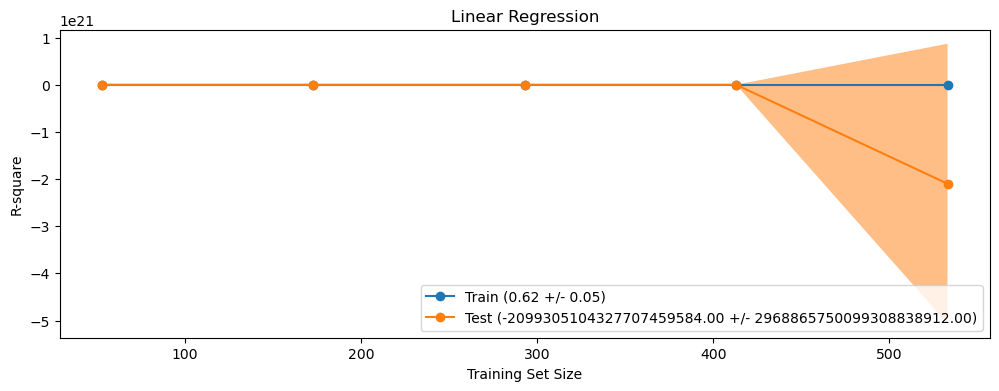

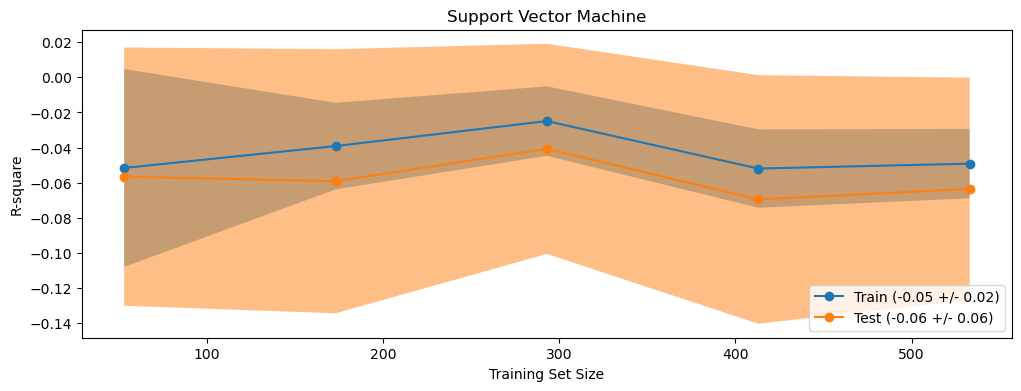

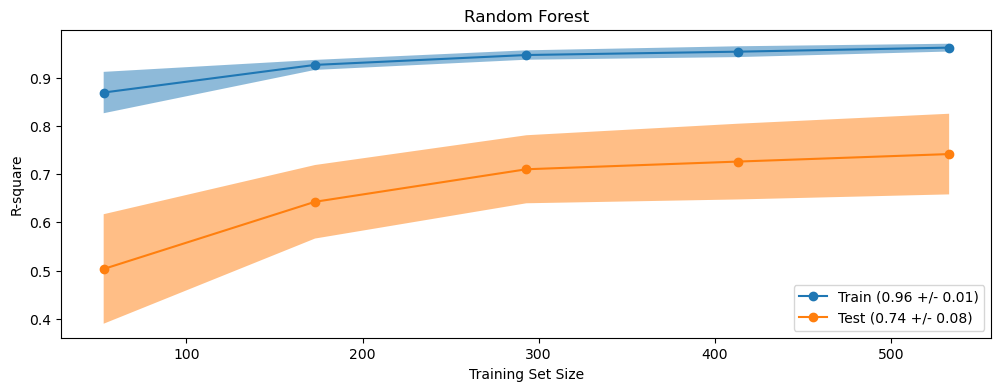

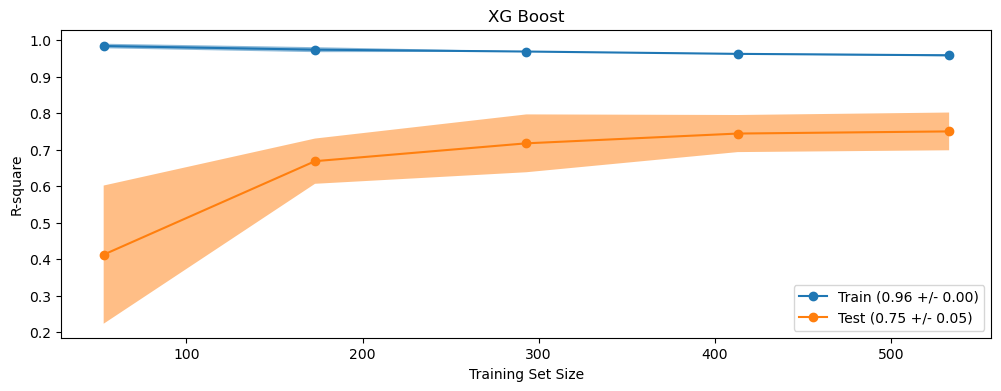

In [24]:
for name, alg in algorithms.items():
	plot_learning_curves(name, alg)

## 6. Model Training

In [25]:
model = Pipeline(steps=[
	("pre", preprocessor),
	("rf", RandomForestRegressor(n_estimators=10))
])

In [26]:
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

## 7. Model Evaluation

In [27]:
def evaluate_model(X, y):
	y_pred = model.predict(X)
	return r2_score(y, y_pred)

In [28]:
print(f"R2 score on Training data is = {evaluate_model(X_data, y_data)}")

R2 score on Training data is = 0.9631442294369829


In [29]:
print(f"R2 score on Test data is = {evaluate_model(X_test, y_test)}")

R2 score on Test data is = 0.8086141939636899


## 8. Model Persistence

In [30]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [31]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [32]:
y_pred = saved_model.predict(X_test)

r2_score(y_test, y_pred)

0.8086141939636899